In [52]:
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

import collections
import cv2
import os
import re
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


def load_image(name, output=False):
    img = cv2.imread(path + '/' + name + '.png')
    # img = cv2.cvtColor(img ,cv2.COLOR_BGR2RGB)

    # normalizing input image using MinMax and convert data to float32 type
    # img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img


def load_mask(name, output=False):
    img = cv2.imread(path + '/' + name + 'm.png', cv2.IMREAD_GRAYSCALE)
    return np.array(img).reshape(img.shape[0], img.shape[1], 1)


def display(display_list, title_list=['Input Image', 'True Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


def print_cluster(result, cluster_tag):
    result_copy = np.zeros((200, 200, 3))
    slice_img = np.where(result == cluster_tag, 1, 0)
    for j in range(3):
        result_copy[:, :, j] = slice_img
    return result_copy


def get_IoU_for_slice(slice_, mask):
    intersection = np.logical_and(slice_, mask)
    union = np.logical_or(slice_, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


def get_IoU(slices):
    return np.array(slices).max(), np.argmax(np.array(slices))


def accuracy_IoU_scorer(result, mask):
    metrics_iou = []
    unique_tags = np.unique(result.flatten())
    for i in unique_tags:
        result_copy = np.zeros((200, 200, 3))
        slice_img = np.where(result == i, 1, 0)

        for j in range(3):
            result_copy[:, :, j] = slice_img

        metrics_iou.append(get_IoU_for_slice(result_copy, mask))

    accuracy, cluster_ind = get_IoU(metrics_iou)
    slice_ = print_cluster(result, np.unique(result.flatten())[cluster_ind])
    return accuracy, slice_


def dbscan(data, eps=0.01, min_samples=6, metric='euclidean'):
    print(f'start DBSCAN with {eps}, {min_samples}')

    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(data)
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    #print("Estimated number of clusters: %d" % n_clusters_)
    #print("Estimated number of noise points: %d" % n_noise_)

    labeled_img = labels.reshape(200, 200)

    return labeled_img


def blur_img(img, blur_param=30, center=(100, 100), radius=60):
    blurred_img = cv2.GaussianBlur(img, (21, 21), blur_param)

    mask = np.zeros(img.shape, dtype=np.uint8)
    mask = cv2.circle(mask, center, radius, (255, 255, 255), -1)

    out = np.where(mask == np.array([255, 255, 255]), img, blurred_img)
    return out

def get_optimal_params(img, mask, param_grid):
    accuracy_list = []
    for eps in param_grid['eps']:
        for min_samples in param_grid['min_samples']:
            dbscan_img = dbscan(img, eps, min_samples)
            accuracy, slice_ = accuracy_IoU_scorer(dbscan_img, mask)
            print(f'--acc = {accuracy} \n')
            accuracy_list.append(accuracy)

    accuracy_matrix = np.array(accuracy_list).reshape(len(param_grid['eps']),\
                                                      len(param_grid['min_samples']))
    eps_ind, min_samples_ind = unravel_index(accuracy_matrix.argmax(), accuracy_matrix.shape)
    print(accuracy_matrix)
    print('\n',accuracy_matrix.max())
    print(param_grid['eps'][eps_ind],'  ', param_grid['min_samples'][min_samples_ind])
    print(unravel_index(accuracy_matrix.argmax(), accuracy_matrix.shape), '\n\n')
    return eps_ind, min_samples_ind

In [54]:
# -------------------SET PATHS-----------------
processed_images_path = '/Users/anastasia/PycharmProjects/pythonProject1/processed_images.txt'
path = '/Users/anastasia/Desktop/Datasets/Total/BlackPupilEye'

# path = '/home/nastya/dataset/test/Total/BlackPupilEye'
# processed_images_path = '/home/nastya/python/processed_images.txt'
# ---------------------------------------------


# -------------------SET RESULT FILE-----------------
accuracy_metrics_path = '/Users/anastasia/PycharmProjects/pythonProject1/metricsDBSCAN.txt'
image_results_path = '/Users/anastasia/PycharmProjects/pythonProject1/images/DBSCAN/'

# image_results_path = 'out/images/DBSCAN/'
# accuracy_metrics_path = 'out/metricsDBSCAN.txt'
# ---------------------------------------------------

image_path_list = os.listdir(path)
image_names = [re.sub('m.png|.png', '', img) for img in image_path_list]
uniq_img_names = list(set(image_names))

# uniq_img_names = get_unprocessed_images(processed_images_path, uniq_img_names)
# n = len(uniq_img_names)

n = 10
images = np.array([load_image(img) for img in tqdm(uniq_img_names[:n])])
masks = np.array([load_mask(img) for img in tqdm(uniq_img_names[:n])])

100%|██████████| 10/10 [00:00<00:00, 1388.89it/s]


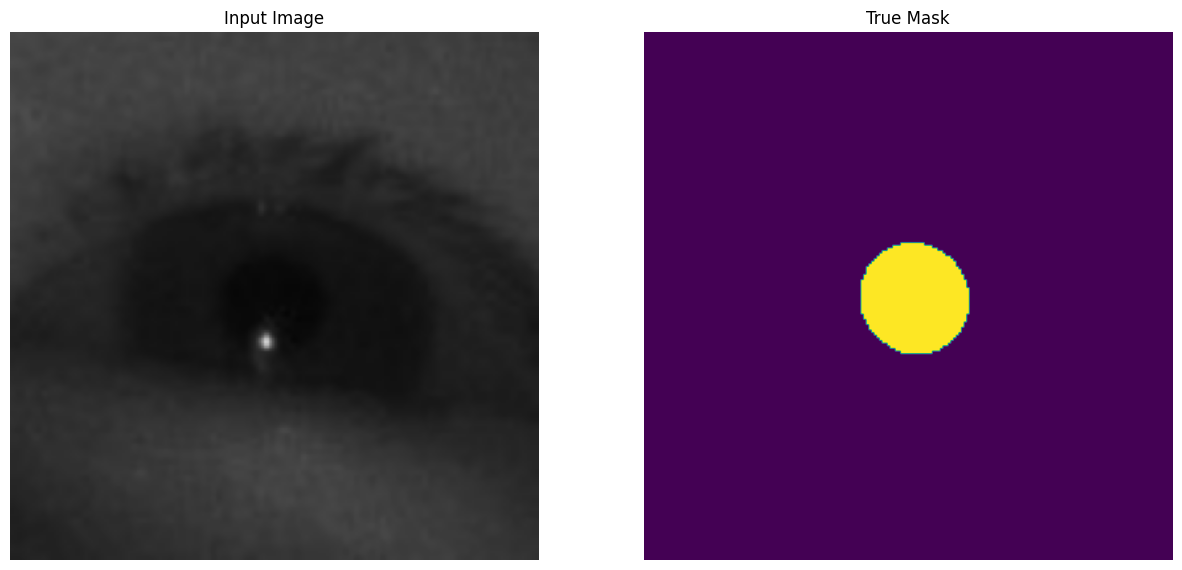

In [56]:
display([images[1], masks[0]])

start DBSCAN with 5, 250
--acc = 0.06762589928057554 

start DBSCAN with 5, 300
--acc = 0.06 

start DBSCAN with 5, 350
--acc = 0.05448354143019296 

start DBSCAN with 5, 400
--acc = 0.05448354143019296 

start DBSCAN with 5, 450
--acc = 0.7596504005826656 

start DBSCAN with 5, 500
--acc = 0.7596504005826656 

start DBSCAN with 5, 550
--acc = 0.7596504005826656 

start DBSCAN with 5, 600
--acc = 0.7596504005826656 

start DBSCAN with 5.5, 250
--acc = 0.06695464362850972 

start DBSCAN with 5.5, 300
--acc = 0.06695464362850972 

start DBSCAN with 5.5, 350
--acc = 0.06695464362850972 

start DBSCAN with 5.5, 400
--acc = 0.06695464362850972 

start DBSCAN with 5.5, 450
--acc = 0.06291834002677377 

start DBSCAN with 5.5, 500
--acc = 0.06201550387596899 

start DBSCAN with 5.5, 550
--acc = 0.057971014492753624 

start DBSCAN with 5.5, 600
--acc = 0.058574879227053143 

start DBSCAN with 6, 250
--acc = 0.06695464362850972 

start DBSCAN with 6, 300
--acc = 0.06695464362850972 

start DBSCA

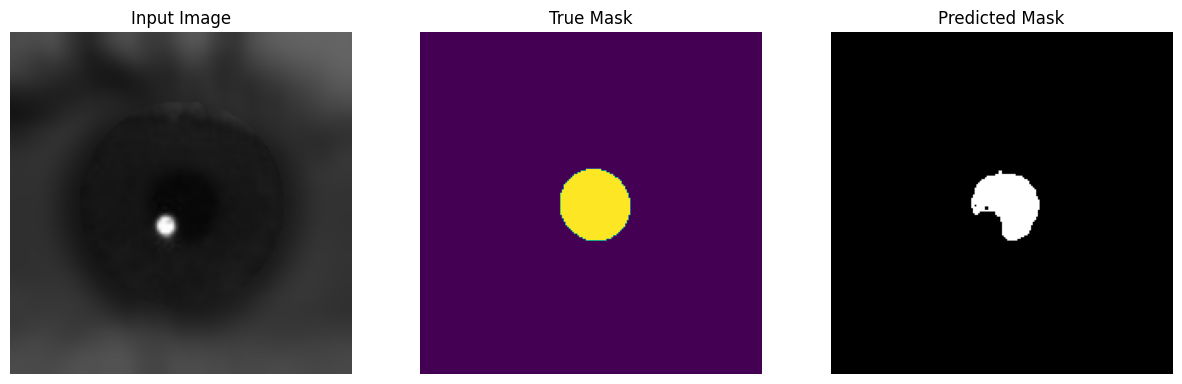

start DBSCAN with 5, 250
--acc = 0.030325 

start DBSCAN with 5, 300
--acc = 0.030325 

start DBSCAN with 5, 350
--acc = 0.030325 

start DBSCAN with 5, 400
--acc = 0.030325 

start DBSCAN with 5, 450
--acc = 0.030325 

start DBSCAN with 5, 500
--acc = 0.030325 

start DBSCAN with 5, 550
--acc = 0.6947791164658634 

start DBSCAN with 5, 600
--acc = 0.6947791164658634 

start DBSCAN with 5.5, 250
--acc = 0.03035 

start DBSCAN with 5.5, 300
--acc = 0.03035 

start DBSCAN with 5.5, 350
--acc = 0.03035 

start DBSCAN with 5.5, 400
--acc = 0.03035 

start DBSCAN with 5.5, 450
--acc = 0.03035 

start DBSCAN with 5.5, 500
--acc = 0.03035 

start DBSCAN with 5.5, 550
--acc = 0.030325 

start DBSCAN with 5.5, 600
--acc = 0.030325 

start DBSCAN with 6, 250
--acc = 0.03035 

start DBSCAN with 6, 300
--acc = 0.03035 

start DBSCAN with 6, 350
--acc = 0.03035 

start DBSCAN with 6, 400
--acc = 0.03035 

start DBSCAN with 6, 450
--acc = 0.03035 

start DBSCAN with 6, 500
--acc = 0.03035 

start DB

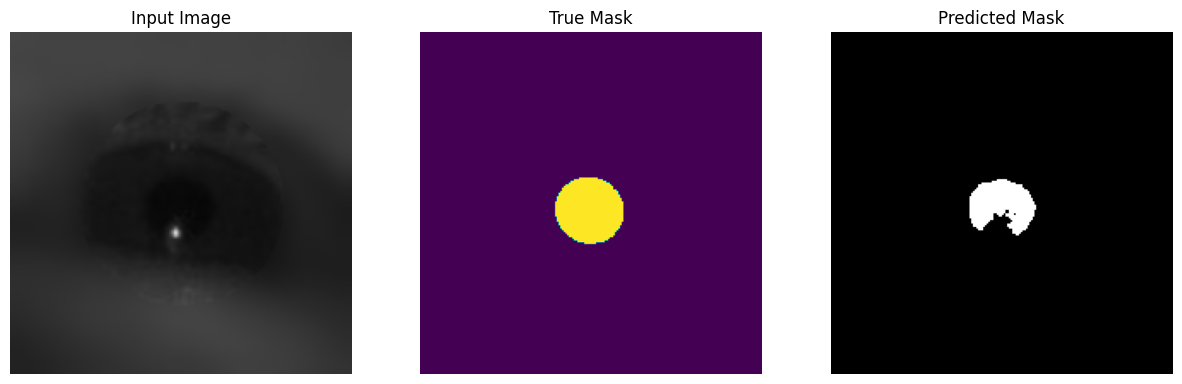

start DBSCAN with 5, 250
--acc = 0.030805093242430318 

start DBSCAN with 5, 300
--acc = 0.03080586539666625 

start DBSCAN with 5, 350
--acc = 0.03080586539666625 

start DBSCAN with 5, 400
--acc = 0.030806637589612475 

start DBSCAN with 5, 450
--acc = 0.7894736842105263 

start DBSCAN with 5, 500
--acc = 0.7894736842105263 

start DBSCAN with 5, 550
--acc = 0.7894736842105263 

start DBSCAN with 5, 600
--acc = 0.7894736842105263 

start DBSCAN with 5.5, 250
--acc = 0.030830158411870864 

start DBSCAN with 5.5, 300
--acc = 0.030830158411870864 

start DBSCAN with 5.5, 350
--acc = 0.030830158411870864 

start DBSCAN with 5.5, 400
--acc = 0.030805093242430318 

start DBSCAN with 5.5, 450
--acc = 0.030805093242430318 

start DBSCAN with 5.5, 500
--acc = 0.030805093242430318 

start DBSCAN with 5.5, 550
--acc = 0.03080586539666625 

start DBSCAN with 5.5, 600
--acc = 0.03080586539666625 

start DBSCAN with 6, 250
--acc = 0.030830158411870864 

start DBSCAN with 6, 300
--acc = 0.030830158

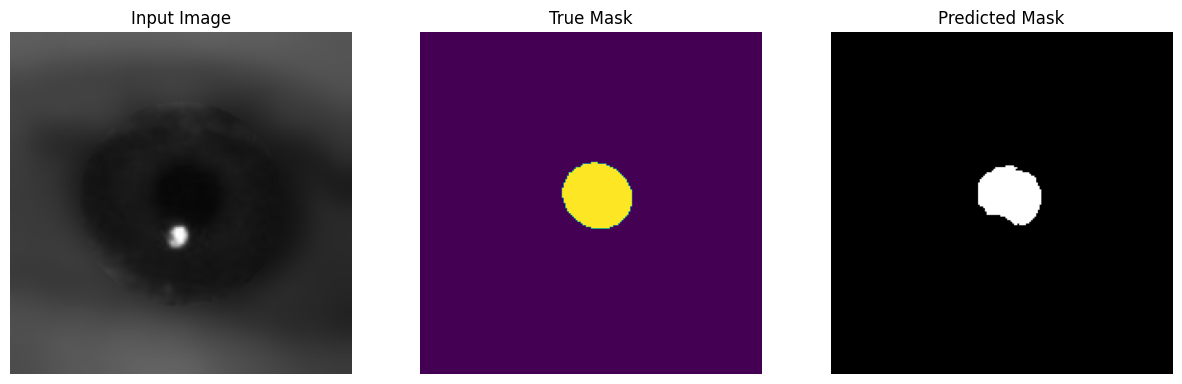

start DBSCAN with 5, 250
--acc = 0.025284481680630237 

start DBSCAN with 5, 300
--acc = 0.025284481680630237 

start DBSCAN with 5, 350
--acc = 0.025285114045618246 

start DBSCAN with 5, 400
--acc = 0.6576663452266153 

start DBSCAN with 5, 450
--acc = 0.7109826589595376 

start DBSCAN with 5, 500
--acc = 0.7109826589595376 

start DBSCAN with 5, 550
--acc = 0.6984585741811176 

start DBSCAN with 5, 600
--acc = 0.5940212150433944 

start DBSCAN with 5.5, 250
--acc = 0.025284481680630237 

start DBSCAN with 5.5, 300
--acc = 0.025284481680630237 

start DBSCAN with 5.5, 350
--acc = 0.025284481680630237 

start DBSCAN with 5.5, 400
--acc = 0.025284481680630237 

start DBSCAN with 5.5, 450


KeyboardInterrupt: 

In [53]:
param_grid = {'eps': [0.05, 0.01, 0.1, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5],
              'min_samples': [250, 300, 350, 400, 450, 500, 550, 600, 700, 800, 900, 1000, 1100, 1300, 1500]}

# param_grid = {'eps': [ 5, 5.5, 6, 6.5],
#               'min_samples': [250, 300, 350, 400, 450, 500, 550, 600]}

for i in range(n):
    out_blur_img = blur_img(images[i], 200)
    img_3f = out_blur_img.reshape((-1, 3))

    eps_ind, min_samples_ind = get_optimal_params(img_3f, masks[i], param_grid)

    optimal_eps = param_grid['eps'][eps_ind]
    optimal_samp = param_grid['min_samples'][min_samples_ind]

    dbscan_img = dbscan(img_3f, optimal_eps, optimal_samp)
    accuracy, slice_ = accuracy_IoU_scorer(dbscan_img, masks[i])

    print(f'\neps={optimal_eps}, min_samp={optimal_samp}, acc = {accuracy}')
    display([out_blur_img, masks[i], slice_])
    with open(accuracy_metrics_path, "a") as f:
        f.write(uniq_img_names[i] + ' ' + str(accuracy) + ' ' + str(optimal_eps) + ' ' + str(optimal_samp)+'\n')
        f.close()

    data_2d = slice_.reshape((-1, slice_.shape[-1]))
    #np.savetxt(image_results_path + (uniq_img_names[i]) + '.txt', data_2d, delimiter=',')
    np.savetxt((uniq_img_names[i]) + '.txt', data_2d, delimiter=',')


print('hehe')